In [2]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook as tqdm
import json
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords  
from wordcloud import WordCloud, STOPWORDS
nltk.download('vader_lexicon')
nltk.download('stopwords')

C:\Users\alvin\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alvin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alvin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
consumerKey = 'insert'
consumerSecret = 'insert'
accessToken = 'insert'
accessTokenSecret = 'insert'

In [3]:
# Create the authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret) 
    
# Set the access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret) 
    
# Creating the API object while passing in auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [4]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

sid = SentimentIntensityAnalyzer()

In [5]:
stateBatches = {
    'states1' : ['AK', 'AL', 'AR', "AZ", 'CA'],
    'states2' : ["CO", 'CT', 'DC', 'DE', 'FL'],
    'states3' : ['GA', 'HI', 'IA', 'ID', 'IL'],
    'states4' : ['IN', 'KS', 'KY', 'LA', 'MA'],
    'states5' : ['MD', 'ME', "MI", 'MN', "MO"],
    'states6' : ["MS", 'MT', 'NC', 'ND', 'NE'],
    'states7' : ['NH', 'NJ', 'NM', 'NV', 'NY'],
    'states8' : ['OH', 'OK', 'OR', 'PA', 'RI'],
    'states9' : ['SC', 'SD', 'TN', 'TX', 'UT'],
    'states10' : ['VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
    'majStates' : ['CA','TX','NY','FL','PA','IL','GA','OH']
}

In [6]:
def readCSV(states):
    ids = {}
    batchNum = 0
    for state in states:
        stateTweets = pd.read_csv('../Source Data/States/'+state+'.csv')['Tweet_ID']
        i = 0
        tweetIds = []
        tempTweets = []
        for tweetId in stateTweets:
            tempTweets.append(tweetId)
            if i == 99:
                tweetIds.append(tempTweets)
                tempTweets = []
                i = -1
                batchNum += 1
            i += 1
        if len(tempTweets) > 0:
            tweetIds.append(tempTweets)
            batchNum += 1
        ids[state] = tweetIds
    return ids, batchNum

In [40]:
dictWordsAll = {}
stop_words = set(stopwords.words('english'))  
def makeCSV(ids, batchNum):
    info = []
    pbar = tqdm(total=batchNum)
    for state in ids.keys():
        for batch in ids[state]:
            pbar.update(1)
            tweets = api.statuses_lookup(batch)
            for tweet in tweets:
                text = tweet.text
                date = str(tweet.created_at).split(" ")[0]
                subj = getSubjectivity(text)
                pol = getPolarity(text)
                vaderPol = sid.polarity_scores(text)['compound']
                info.append([state, date, tweet.id, subj, pol, vaderPol])
                text = text.split()
                for word in text:
                    word = word.lower()
                    word = word.rstrip(";")
                    word = word.rstrip(":")
                    word = word.rstrip(".")
                    word = word.rstrip("!")
                    word = word.rstrip("?")
                    word = word.rstrip("|")
                    word = word.rstrip("-")
                    if word not in stop_words:
                        if word in dictWordsAll:
                            dictWordsAll[word] +=1
                        else:
                            dictWordsAll[word] = 1
    return info
    pbar.close()

In [83]:
stop_words = set(stopwords.words('english'))  
def posNeg(ids, batchNum):
    pbar = tqdm(total=batchNum)
    for state in ids.keys():
        for batch in ids[state]:
            pbar.update(1)
            tweets = api.statuses_lookup(batch)
            for tweet in tweets:
                text = tweet.text
                vaderPol = sid.polarity_scores(text)['compound']
                text = text.split()
                for word in text:
                    word = word.lower()
                    word = word.rstrip(";")
                    word = word.rstrip(":")
                    word = word.rstrip(".")
                    word = word.rstrip("!")
                    word = word.rstrip("?")
                    word = word.rstrip("|")
                    word = word.rstrip("-")
                    if vaderPol > 0:
                        if word not in stop_words:
                            if word in posWords:
                                posWords[word] +=1
                            else:
                                posWords[word] = 1
                    if vaderPol < 0:
                        if word not in stop_words:
                            if word in negWords:
                                negWords[word] +=1
                            else:
                                negWords[word] = 1
                break
    pbar.close()

In [8]:
def saveCSV(info, name):
    saver = pd.DataFrame(info)
    saver.columns = ['state', 'date', 'tweet_id', 'subj', 'pol', 'vaderPol']
    saver.to_csv('./State Batches/'+name+".csv", index=False)

In [42]:
for stateBatch in stateBatches.keys():
    test, batchNum = readCSV(stateBatches[stateBatch])
    test2 = makeCSV(test, batchNum)
    saveCSV(test2, stateBatch)

KeyboardInterrupt: 

In [84]:
for stateBatch in ['majStates']:
    test, batchNum = readCSV(stateBatches[stateBatch])
    posWords = {}
    negWords = {}
    posNeg(test, batchNum)

Escape from New York! https://t.co/4Jk3SoZ3aX
Escape
from
New
York!
https://t.co/4Jk3SoZ3aX
A dr begs the greedy 🤡. Don't listen to the 🤡. Listen to the dr. Stay home, people. Just that home.

https://t.co/76mejIsdcx
A
dr
begs
the
greedy
🤡.
Don't
listen
to
the
🤡.
Listen
to
the
dr.
Stay
home,
people.
Just
that
home.
https://t.co/76mejIsdcx
I haven’t said anything about COVID-19, but man....this shit has your boy struggling out here. Hours got cut sooooooooo bad. 😭
I
haven’t
said
anything
about
COVID-19,
but
man....this
shit
has
your
boy
struggling
out
here.
Hours
got
cut
sooooooooo
bad.
😭
@PoddarVaishali @TajinderBagga @cooldeep Why is the Guy touching the IDs and hands? No social distancing.
@PoddarVaishali
@TajinderBagga
@cooldeep
Why
is
the
Guy
touching
the
IDs
and
hands?
No
social
distancing.


KeyboardInterrupt: 

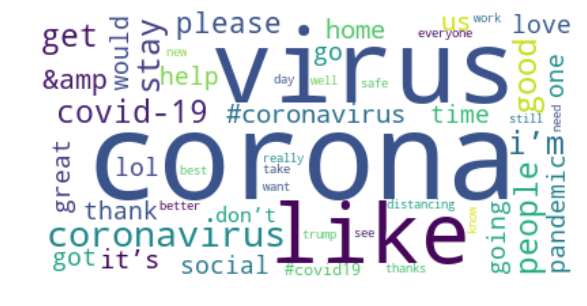

In [34]:
wordcloud = WordCloud(background_color = "white", max_words=50, stopwords=STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=posWords)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

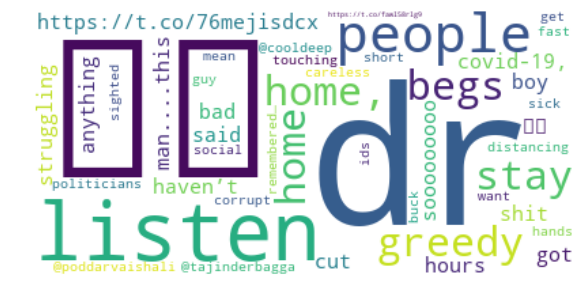

In [49]:
wordcloud = WordCloud(background_color = "white", max_words=50, stopwords=STOPWORDS)
wordcloud.generate_from_frequencies(frequencies=negWords)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Attempts at getting emoji to show